# Exploration12 - 트랜스포머로 만드는 대화형 챗봇
트랜스포머 모델로 한국어 챗봇을 만들어보자.

---

### 루브릭 평가 기준

1. 한국어 전처리를 통한 학습 데이터셋 구축 - 공백과 특수문자 처리, 토크나이징, 병렬 데이터 구축의 과정이 진행되었나
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습 진행 - 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였나
3. 한국어 입력 문장에 대해 한국어로 답변하는 함수 구현 - 한국어 입력 문장에 그럴듯한 한국어 답변을 리턴하였나

---

### 목차

0) 필요 모듈 import


1) 데이터 로드 및 전처리
  - 데이터 준비
  - 데이터 전처리
    

2) 모델 설계 및 훈련


3) 모델 테스트


4) 회고

## 0. 필요 모듈 import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## 1. 데이터 로드 및 전처리

### - 데이터 준비

한국어로 된 질문과 답변이 담긴 [한국어 챗봇 데이터](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)를 다운받아 사용한다.

In [2]:
data = pd.read_csv('./data/ChatbotData.csv')
data.shape

(11823, 3)

In [3]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### - 데이터 전처리 : 데이터 정리

텍스트를 정제하고 질문과 답변을 나누어준다.

In [4]:
def preprocess_sentence(sentence):    
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # (한글, 알파벳, 숫자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [5]:
preprocess_sentence(data['Q'][1])

'1지망 학교 떨어졌어'

In [6]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 함수
def load_conversations():
    inputs, outputs = [], []
    
    for i in range(len(data)):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(data['Q'][i]))
        outputs.append(preprocess_sentence(data['A'][i]))
        
    return inputs, outputs

In [7]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()

print('전체 질문 샘플 수 :', len(questions))
print('전체 답변 샘플 수 :', len(answers))

전체 질문 샘플 수 : 11823
전체 답변 샘플 수 : 11823


#### 전처리 결과 확인

In [8]:
for i in range(10,20,2):
    print('전처리 후의 {}번째 질문 샘플: {}'.format(i+1, questions[i]))
    print('전처리 후의 {}번째 답변 샘플: {}'.format(i+1, answers[i]))
    print('-'*65)

전처리 후의 11번째 질문 샘플: SNS보면 나만 빼고 다 행복해보여
전처리 후의 11번째 답변 샘플: 자랑하는 자리니까요 .
-----------------------------------------------------------------
전처리 후의 13번째 질문 샘플: 가끔 뭐하는지 궁금해
전처리 후의 13번째 답변 샘플: 그 사람도 그럴 거예요 .
-----------------------------------------------------------------
전처리 후의 15번째 질문 샘플: 가난한 자의 설움
전처리 후의 15번째 답변 샘플: 돈은 다시 들어올 거예요 .
-----------------------------------------------------------------
전처리 후의 17번째 질문 샘플: 가상화폐 쫄딱 망함
전처리 후의 17번째 답변 샘플: 어서 잊고 새출발 하세요 .
-----------------------------------------------------------------
전처리 후의 19번째 질문 샘플: 가스불 켜놓고 나온거 같아
전처리 후의 19번째 답변 샘플: 빨리 집에 돌아가서 끄고 나오세요 .
-----------------------------------------------------------------


### - 데이터 전처리 : SubwordTextEncoder를 사용한 토큰화  
단어장을 생성하고 정수 인코딩 및 패딩을 진행한다.

#### 단어장 생성

In [9]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성.
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers,
                                                                      target_vocab_size=2**13)

In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1] #기존 단어장 뒤로 붙여줌

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8162]
END_TOKEN의 번호 : [8163]


In [11]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8164


#### 정수 인코딩

In [12]:
# 임의의 10번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('전처리 후의 9번 질문 샘플: {}'.format(questions[9]))
print('전처리 후의 9번 답변 샘플: {}'.format(answers[9]))
print('-'*65)
print('정수 인코딩 후의 9번 질문 샘플: {}'.format(tokenizer.encode(questions[9])))
print('정수 인코딩 후의 9번 답변 샘플: {}'.format(tokenizer.encode(answers[9])))

전처리 후의 9번 질문 샘플: SNS 시간낭비인데 자꾸 보게됨
전처리 후의 9번 답변 샘플: 시간을 정하고 해보세요 .
-----------------------------------------------------------------
정수 인코딩 후의 9번 질문 샘플: [2159, 778, 7598, 204, 84, 184, 351, 1255]
정수 인코딩 후의 9번 답변 샘플: [349, 3977, 16, 32, 1]


#### 패딩
패딩을 통해 데이터를 동일한 길이로 맞춘다.  
문장의 최대 길이를 정하기 위해 데이터의 전체적인 길이 분포를 확인해보자.

질문의 최소 길이 : 1
질문의 최대 길이 : 15
질문의 평균 길이 : 3.587414361837097
답변의 최소 길이 : 1
답변의 최대 길이 : 21
답변의 평균 길이 : 3.6936479742874058


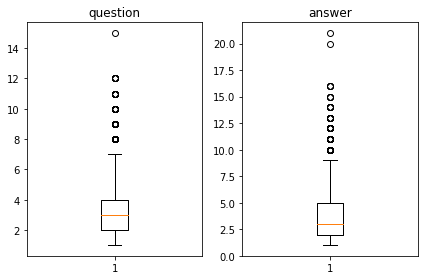

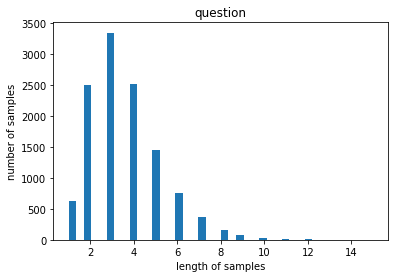

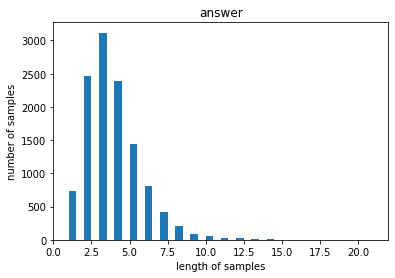

In [13]:
# 길이 분포 출력
question_len = [len(s.split()) for s in data['Q']]
answer_len = [len(s.split()) for s in data['A']]

print('질문의 최소 길이 : {}'.format(np.min(question_len)))
print('질문의 최대 길이 : {}'.format(np.max(question_len)))
print('질문의 평균 길이 : {}'.format(np.mean(question_len)))
print('답변의 최소 길이 : {}'.format(np.min(answer_len)))
print('답변의 최대 길이 : {}'.format(np.max(answer_len)))
print('답변의 평균 길이 : {}'.format(np.mean(answer_len)))

plt.subplot(1,2,1)
plt.boxplot(question_len)
plt.title('question')
plt.subplot(1,2,2)
plt.boxplot(answer_len)
plt.title('answer')
plt.tight_layout()
plt.show()

plt.title('question')
plt.hist(question_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answer')
plt.hist(answer_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

대부분의 질문과 답변이 포함될 수 있도록 문장의 최대 길이를 10으로 하겠다.

In [14]:
MAX_LENGTH = 10

정수 인코딩 과정에서 붙는 시작 토큰과 종료 토큰을 고려해 최대 길이를 2만큼 늘려준다.

In [15]:
MAX_LENGTH += 2

질문과 답변에 대해서 전부 정수 인코딩을 수행하고, 동시에 문장의 최대 길이로 패딩한다.

In [16]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 6 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
        
    # 최대 길이로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

11823개의 데이터 중 10746개의 데이터만 남게 된다.

In [17]:
questions, answers = tokenize_and_filter(questions, answers)

print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 10746
필터링 후의 답변 샘플 개수: 10746


#### 교사 강요(Teacher Forcing) 사용
교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용한다.

In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 12000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 2. 모델 설계 및 훈련

#### 포지셔널 인코딩 레이어

In [19]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
        
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

#### 스케일드 닷 프로덕트 어텐션

In [20]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)
    
    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

#### 멀티 헤드 어텐션

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        
        return tf.transpose(inputs, perm=[0, 2, 1, 3])


    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)
        
        return outputs

####  패딩 마스킹
0의 위치를 체크

In [22]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

#### 룩 어헤드 마스킹
다음 단어를 가림

In [23]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

#### 인코더

In [24]:
# 인코더 층
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
    
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

인코더 층을 embedding layer와 positional encoding을 연결하고, 원하는 만큼 인코더 층을 쌓아 트랜스포머의 인코더를 만든다.

In [25]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
        
        return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 디코더

In [26]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
    
    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)
    
    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
    
    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)
    
    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [27]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
        return tf.keras.Model(
            inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
            outputs=outputs,
            name=name)

#### 트랜스포머 함수 정의

In [28]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])
    
    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### 모델 생성

In [29]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2617088     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 손실함수

In [30]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

#### 커스텀 된 학습률  
모델 학습 초기에 높였다가 서서히 낮추어 가는 고급 기법 - 커스텀 학습률 스케줄링

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#### 모델 컴파일

In [32]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### 훈련 진행

In [33]:
EPOCHS = 40
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/40
168/168 [==============================] - 7s 21ms/step - loss: 4.8745 - accuracy: 0.0891
Epoch 2/40
168/168 [==============================] - 3s 20ms/step - loss: 3.9833 - accuracy: 0.1746
Epoch 3/40
168/168 [==============================] - 3s 20ms/step - loss: 3.3305 - accuracy: 0.1775
Epoch 4/40
168/168 [==============================] - 3s 20ms/step - loss: 3.0324 - accuracy: 0.1875
Epoch 5/40
168/168 [==============================] - 3s 20ms/step - loss: 2.8383 - accuracy: 0.1989
Epoch 6/40
168/168 [==============================] - 3s 20ms/step - loss: 2.6490 - accuracy: 0.2117
Epoch 7/40
168/168 [==============================] - 3s 21ms/step - loss: 2.4461 - accuracy: 0.2303
Epoch 8/40
168/168 [==============================] - 3s 20ms/step - loss: 2.2210 - accuracy: 0.2559
Epoch 9/40
168/168 [==============================] - 3s 20ms/step - loss: 1.9692 - accuracy: 0.2845
Epoch 10/40
168/168 [==============================] - 3s 20ms/step - loss: 1.6988 - accura

## 3. 모델 테스트
아래의 과정을 담은 함수를 만든다.
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. _TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [34]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    
    return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 챗봇의 대답을 얻는 함수

In [35]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
    
    return predicted_sentence

#### 결과 확인

In [36]:
sentence_generation('저녁 뭐먹지?')

입력 : 저녁 뭐먹지?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

원래의 데이터는  
Q : 오늘 저녁 뭐 먹을까  
A : 맛있는 거 드세요.  
의 구성으로 되어있다.  
비슷한 질문에 대해서는 학습 데이터에 있던 대답을 잘 출력한다.

In [37]:
sentence_generation('우리집 고양이는 귀여워')

입력 : 우리집 고양이는 귀여워
출력 : 저도 보고 싶어요 .


'저도 보고 싶어요 .'

고양이와 관련된 데이터에서는 해당 답변이 없는데,  
Q : 눈썹이 귀여워  
A : 저도 보고 싶어요  
이와 같이 '귀엽다'와 관련된 데이터가 있었다.  
귀엽다를 인식하고 동일한 답변을 내놓은 듯 하다.

In [38]:
sentence_generation('돈 벌고 싶어')

입력 : 돈 벌고 싶어
출력 : 많이 벌수록 좋아요 .


'많이 벌수록 좋아요 .'

데이터셋에 포함된 질문을 변형 없이 그대로 던지니 답변 또한 그대로 돌아왔다. 

In [39]:
sentence_generation('친구랑 여행 갈거야')

입력 : 친구랑 여행 갈거야
출력 : 좋은 생각이에요 .


'좋은 생각이에요 .'

가족들이랑 여행간다는 질문에 좋은 생각이라고 답변하는 데이터가 2개 정도 있었다.    
Q : 가족들이랑 여행 갈거야 / 가족이랑 여행 가려고    
A : 좋은 생각이에요  
'여행을 간다'라는 것을 인식하고 동일한 답변을 한 것 같다. 

In [40]:
sentence_generation('나는 벌레가 싫어')

입력 : 나는 벌레가 싫어
출력 : 당신은 복받은 사람 .


'당신은 복받은 사람 .'

Q : 여자친구가 너무 예뻐 / 여친 진짜 예쁘다    
A : 당신은 복받은 사람  
학습 데이터에서 복받은 사람이라는 답변을 내놓는 질문은 이 두개뿐이다.  
어째서 벌레와 여자친구를 동일하게 인식하게 된걸까...? 

In [41]:
sentence_generation('너는 무슨 색깔을 좋아해?')

입력 : 너는 무슨 색깔을 좋아해?
출력 : 다른 사람들이 원하는 내가 되는 건 어려워요 .


'다른 사람들이 원하는 내가 되는 건 어려워요 .'

챗봇에게 '좋아하다'라는 주관적 감정을 물어보는 것은 아직 어려운 일인 것 같다.

In [42]:
sentence_generation('이제 곧 방학이야!')

입력 : 이제 곧 방학이야!
출력 : 더 좋은 날들이 올 거예요 .


'더 좋은 날들이 올 거예요 .'

더 좋은 날들이 온다는 답변은 모두 연인과 헤어졌다는 질문에 대한 세트였는데 방학을 무엇이라 생각하는걸까?   
방학과 관련된 데이터는 많은 편이었음에도 전혀 다른 답변을 내놓고 있다. 

In [43]:
sentence_generation('나는 여름이 싫어')

입력 : 나는 여름이 싫어
출력 : 저도 좀 알려주세요 .


'저도 좀 알려주세요 .'

로봇에게 나의 불호를 얘기하였더니 적절한 답변을 얻지 못했다.  
학습 데이터에서 저도 좀 알려달라는 답변은 모두 돈과 관련된 질문에 대한 내용이었는데 여름과 돈에 나도 모르는 어떤 상관관계가?!

## 4. 회고

#### - NLP 중 노드 중 가장 재미있다!!
모델을 설계하는 부분이 복잡하고 이해하기 어렵지만 그래도 눈에 보이는 결과가 빠르게 나와서 그런가 제일 재미있게 한 것 같다.   
모델의 정확도가 한참 낮긴 하지만 그래도 약간의 변형만 거친 데이터에서 대해서는 그럴듯한 답변을 내놓는게 제법 귀여워보인다.  
아직 챗봇이라고 하기에는 많이 미숙하지만 이정도면 그래도 괜찮아..!!  

